# Berlin Airbnb - predicting price

This notebook is to predict Airbnb price in Berlin for different room types based on the dataset provided on Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from xgboost import XGBRFRegressor as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

### Loading the dataset

In [2]:
data_init = pd.read_csv('./listings_summary.csv')

print("The dataset has {} rows and {} columns.".format(*data_init.shape))

The dataset has 22552 rows and 96 columns.


In [3]:
data_init.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

### Which columns to be used as features?

In [4]:
data_init.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42


In [5]:
col_to_keep = ['id', 'description', 'host_has_profile_pic','host_identity_verified', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy','number_of_reviews',
       'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']
data_raw = data_init[col_to_keep].set_index('id')


In [6]:
data_raw.room_type.value_counts(normalize = True)

Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64

In [7]:
data_raw.isna().sum()

description                       203
host_has_profile_pic               26
host_identity_verified             26
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     22106
price                               0
cleaning_fee                     7146
security_deposit                 9361
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
number_of_reviews                   0
review_scores_rating             4389
review_scores_accuracy           4414
review_score

#### Drop those that have a lot of NAs

In [8]:
data_raw.drop(columns=['square_feet'], inplace = True)

#### Fill NAs with suitable values

In [9]:
data_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
2015,$60.00,$30.00,$28.00,$200.00
2695,$17.00,$0.00,$0.00,$0.00
3176,$90.00,$50.00,$20.00,$200.00


In [10]:
# Replace by 0.00, i.e. no cost
data_raw.cleaning_fee.fillna('$0.00', inplace = True)
data_raw.security_deposit.fillna('$0.00', inplace = True)

In [11]:
# Drop NAs records 
data_raw.dropna(subset=['bedrooms','bathrooms'], inplace = True)
#data_raw.dropna(subset= ['description'], inplace = True)
data_raw.dropna(subset = ['review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value'], inplace = True)

In [12]:
data_raw.isna().sum()

description                     128
host_has_profile_pic             13
host_identity_verified           13
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication 

In [13]:
data_raw.host_has_profile_pic.value_counts()                        

t    18019
f       36
Name: host_has_profile_pic, dtype: int64

In [14]:
# Replace NA profile pic with f
data_raw.host_has_profile_pic.fillna('f', inplace = True)

In [15]:
data_raw.host_identity_verified.fillna('f', inplace = True)

In [16]:
data_raw.isna().sum()

description                     128
host_has_profile_pic              0
host_identity_verified            0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication 

## Explore the individual columns

In [17]:
# There are thousands seprator ',' as well
data_raw.price = data_raw.price.str.replace('$','').str.replace(',','').astype(float)

In [18]:
data_raw.price.describe()

count    18068.000000
mean        62.210372
std        148.844076
min          0.000000
25%         31.000000
50%         46.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

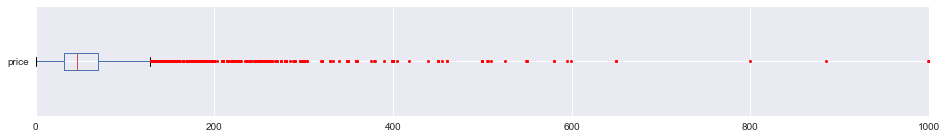

In [19]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
data_raw['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [20]:
## There are quite many outliner whilst 75% of price is at 70usd, could be good to put an upper limit
data_raw.drop(data_raw[(data_raw['price'] > 400) | (data_raw['price'] ==0)].index,axis = 0, inplace = True)

In [21]:
data_raw.price.describe()

count    18014.000000
mean        57.652604
std         41.257503
min          1.000000
25%         31.000000
50%         46.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [22]:
## Apply the same transform for other features
data_raw.extra_people = data_raw.extra_people.str.replace('$','').str.replace(',','').astype(float)
data_raw.cleaning_fee = data_raw.cleaning_fee.str.replace('$','').str.replace(',','').astype(float)
data_raw.security_deposit = data_raw.security_deposit.str.replace('$','').str.replace(',','').astype(float)

In [23]:
data_raw.extra_people.describe()

count    18014.000000
mean         9.084379
std         11.121910
min          0.000000
25%          0.000000
50%          8.000000
75%         15.000000
max        250.000000
Name: extra_people, dtype: float64

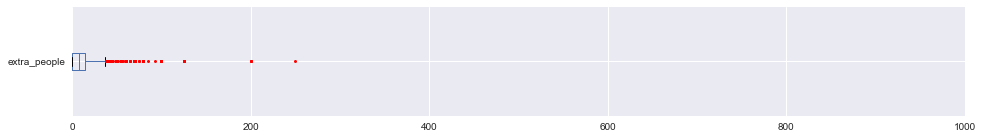

In [24]:
data_raw.extra_people.plot(kind = 'box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2))

## Calculate distance to central Berlin

In [25]:
# Using great circle to calculate distance
from geopy.distance import great_circle

In [26]:
# This idea taken from the kernel by Britta Bettendorf
def dist(lat,lon):
    loc = (lat,lon)
    berlin_centre = (52.5027778, 13.404166666666667)
    distance = great_circle(loc,berlin_centre).km
    return(distance)

In [27]:
data_raw['distance'] = data_raw.apply(lambda x: dist(x.latitude,x.longitude),axis = 1) 

In [28]:
data_raw.distance.head(3)

id
2015    3.533182
2695    5.085573
3176    3.695677
Name: distance, dtype: float64

## Process to get the room size which can be an important feature

In [29]:
data_raw.columns

Index(['description', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'bed_type', 'amenities', 'price', 'cleaning_fee', 'security_deposit',
       'extra_people', 'guests_included', 'minimum_nights', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'distance'],
      dtype='object')

In [30]:
data_raw.description.head(3)

id
2015    Great location!  30 of 75 sq meters. This wood...
2695    In the summertime we are spending most of our ...
3176    This beautiful first floor apartment  is situa...
Name: description, dtype: object

#### Extract size from description

The description column seems to be rich in content. Let's extract

all double-digit or three-digit numbers  
that are followed by one of the two characters "s" or "m" (covering "sqm", "square meters", "m2" etc.) and  
may or may not be connected by white space.


In [31]:
# extract numbers 
data_raw['size'] = data_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
data_raw['size'] = data_raw['size'].str.replace("\D", "")

# change datatype of size into float
data_raw['size'] = data_raw['size'].astype(float)

print('NaNs in size_column absolute:     ', data_raw['size'].isna().sum())
print('NaNs in size_column in percentage:', round(data_raw['size'].isna().sum()/len(data_raw),3), '%')

NaNs in size_column absolute:      9112
NaNs in size_column in percentage: 0.506 %


In [32]:
data_raw['size'].head(3)

id
2015    75.0
2695    25.0
3176    68.0
Name: size, dtype: float64

In [33]:
# Drop description column
data_raw.drop(['description'],axis = 1, inplace = True)

In [34]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18014 entries, 2015 to 29740105
Data columns (total 31 columns):
host_has_profile_pic            18014 non-null object
host_identity_verified          18014 non-null object
neighbourhood_group_cleansed    18014 non-null object
latitude                        18014 non-null float64
longitude                       18014 non-null float64
property_type                   18014 non-null object
room_type                       18014 non-null object
accommodates                    18014 non-null int64
bathrooms                       18014 non-null float64
bedrooms                        18014 non-null float64
bed_type                        18014 non-null object
amenities                       18014 non-null object
price                           18014 non-null float64
cleaning_fee                    18014 non-null float64
security_deposit                18014 non-null float64
extra_people                    18014 non-null float64
guests_include

### Using linear regression to fill NAs in space/size
Use only numerical features for the sake of simplicity

In [35]:
num_features = ['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']
sub_data = data_raw[num_features]

In [36]:
# Split dataset

train_df = sub_data[sub_data['size'].notnull()]
test_df = sub_data[sub_data['size'].isnull()]

In [37]:
x_train = train_df.drop(['size'],axis = 1)
y_train = train_df['size']
x_test = test_df.drop(['size'],axis = 1)

In [38]:
# Fit the linear model
LM = LinearRegression()
LM.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
y_test = LM.predict(x_test)

In [40]:
y_test = pd.DataFrame(y_test)

In [41]:
y_test.columns = ['size']

In [42]:
y_test_index = pd.DataFrame(x_test.index)
y_test_index.columns = ['index']

In [43]:
y_test = pd.concat([y_test,y_test_index],axis = 1)

In [44]:
y_test.set_index(['index'], inplace=True)
y_test.head()

,size
index,
14325,59.200531
20858,97.404007
21869,78.032422
22415,88.117767
28156,68.819986


In [45]:
new_test = pd.concat([x_test,y_test],axis = 1)
new_test.head()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,59.200531
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,97.404007
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,78.032422
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.117767
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,68.819986


In [46]:
sub_data = pd.concat([train_df,new_test],axis = 0)

In [47]:
sub_data.isna().sum()

accommodates        0
bathrooms           0
bedrooms            0
price               0
cleaning_fee        0
security_deposit    0
extra_people        0
guests_included     0
distance            0
size                0
dtype: int64

In [48]:
data_object = data_raw.drop(num_features, axis = 1)
data_new = pd.concat([data_object,sub_data], axis = 1)

In [49]:
data_new.head()

,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,...,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
2015,t,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,...,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0
2695,t,t,Pankow,52.548513,13.404553,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",2,...,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0
3176,t,t,Pankow,52.534996,13.417579,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",62,...,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.0
3309,t,t,Tempelhof - Schöneberg,52.498855,13.349065,Apartment,Private room,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",5,...,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.0
7071,t,t,Pankow,52.543157,13.415091,Apartment,Private room,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",2,...,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.0


In [50]:
data_new['size'].describe()

count    18014.000000
mean        60.890421
std         82.181713
min          0.000000
25%         24.000000
50%         50.000000
75%         65.916955
max        980.000000
Name: size, dtype: float64

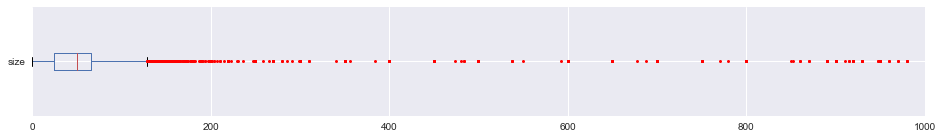

In [51]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
data_new['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [52]:
data_new.drop(data_new[(data_new['size'] == 0.)|(data_new['size'] > 300)].index, axis = 0, inplace = True  )

In [53]:
data_new['size'].describe()

count    17656.000000
mean        52.953106
std         39.375358
min          1.000000
25%         24.000000
50%         49.988195
75%         65.000000
max        300.000000
Name: size, dtype: float64

In [54]:
data_new.amenities.head(3)

2015    {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...
2695    {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...
3176    {Internet,Wifi,Kitchen,"Buzzer/wireless interc...
Name: amenities, dtype: object

In [55]:
from collections import Counter

In [56]:
results = Counter()
data_new['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 16997),
 ('Heating', 16748),
 ('Kitchen', 16743),
 ('Essentials', 16280),
 ('Washer', 14541),
 ('Hair dryer', 12274),
 ('Laptop friendly workspace', 11710),
 ('Hangers', 11291),
 ('Iron', 9145),
 ('Shampoo', 8756),
 ('Hot water', 8655),
 ('TV', 7919),
 ('Family/kid friendly', 6778),
 ('Internet', 6428),
 ('Host greets you', 6000),
 ('Smoke detector', 5198),
 ('Buzzer/wireless intercom', 4966),
 ('Free street parking', 4754),
 ('Refrigerator', 4680),
 ('Dishes and silverware', 4566),
 ('Bed linens', 4369),
 ('Cooking basics', 4345),
 ('Stove', 4317),
 ('Lock on bedroom door', 4277),
 ('Oven', 3851),
 ('Elevator', 3725),
 ('translation missing: en.hosting_amenity_50', 3652),
 ('Smoking allowed', 3562),
 ('Coffee maker', 3264),
 ('First aid kit', 3258)]

In [57]:
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

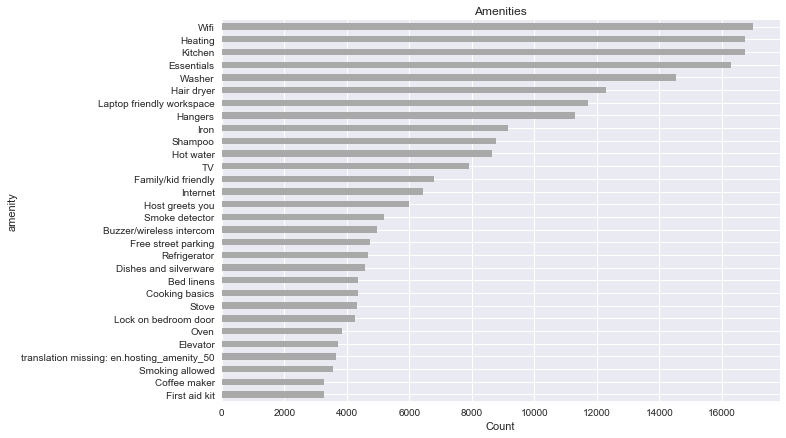

In [58]:
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

In [59]:
sub_df.head()

,amenity,count
0,Wifi,16997
1,Heating,16748
2,Kitchen,16743
3,Essentials,16280
4,Washer,14541


In [60]:
data_new.shape

(17656, 31)

### Creating additional features for some top common amenities

In [61]:
df = data_new

In [62]:
for i in sub_df['amenity']:
    df[i] = df['amenities'].str.contains(i)

In [63]:
df.columns

Index(['host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'bed_type', 'amenities', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'accommodates', 'bathrooms', 'bedrooms', 'price',
       'cleaning_fee', 'security_deposit', 'extra_people', 'guests_included',
       'distance', 'size', 'Wifi', 'Heating', 'Kitchen', 'Essentials',
       'Washer', 'Hair dryer', 'Laptop friendly workspace', 'Hangers', 'Iron',
       'Shampoo', 'Hot water', 'TV', 'Family/kid friendly', 'Internet',
       'Host greets you', 'Smoke detector', 'Buzzer/wireless intercom',
       'Free street parking', 'Refrigerator', 'Dishes and silverwa

### Exploratory data analysis

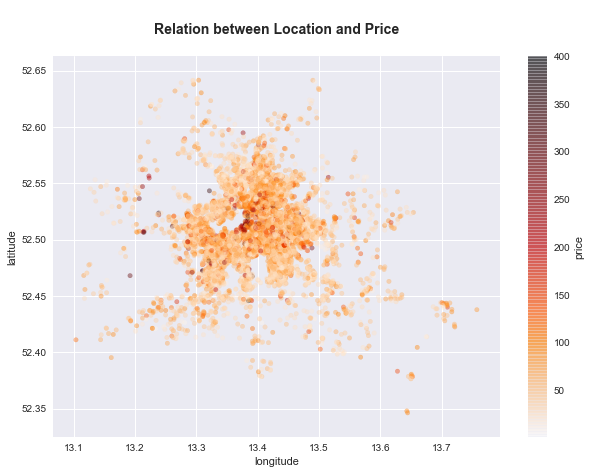

In [64]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);
plt.title('\nRelation between Location and Price\n', fontsize=14, fontweight='bold');

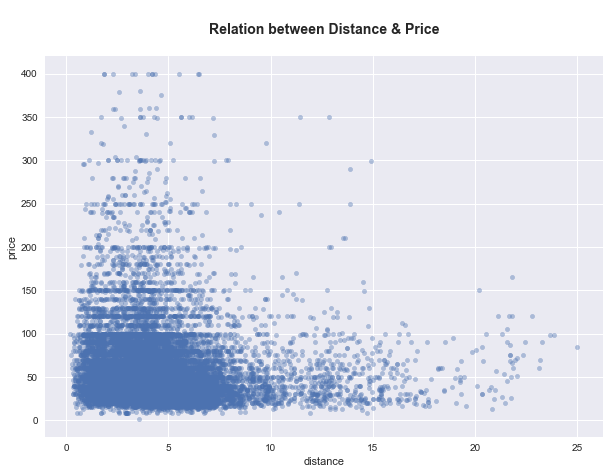

In [65]:
df.plot(kind="scatter", y="price", x="distance", alpha=0.4, figsize=(10,7));
plt.title('\nRelation between Distance & Price\n', fontsize=14, fontweight='bold');

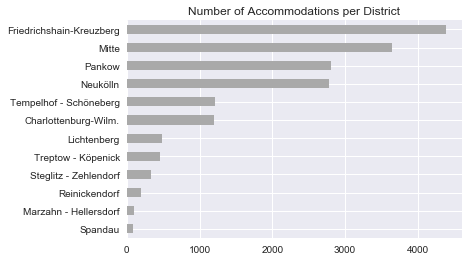

In [66]:
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');

In [67]:
df_group = pd.DataFrame(df.groupby(by = ['neighbourhood_group_cleansed'])['price'].agg(np.median)).reset_index()

In [68]:
df_group

,neighbourhood_group_cleansed,price
0,Charlottenburg-Wilm.,48.0
1,Friedrichshain-Kreuzberg,48.5
2,Lichtenberg,39.0
3,Marzahn - Hellersdorf,50.0
4,Mitte,50.0
5,Neukölln,40.0
6,Pankow,50.0
7,Reinickendorf,35.0
8,Spandau,36.0
9,Steglitz - Zehlendorf,44.5


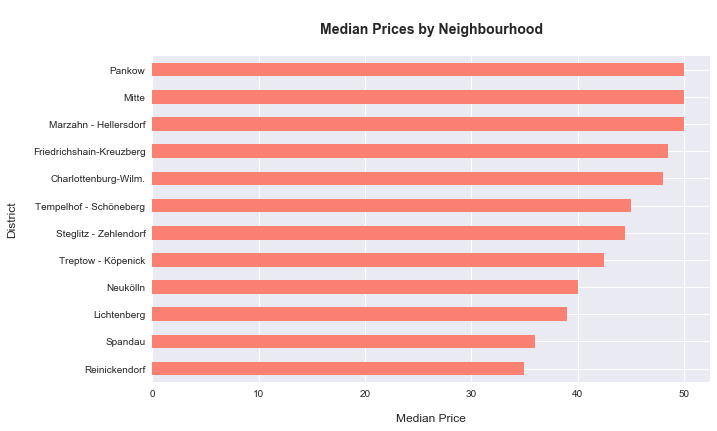

In [69]:
df_group.sort_values(by = ['price'],ascending=True).plot(kind = 'barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(10,6), legend=False, color='salmon')
plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

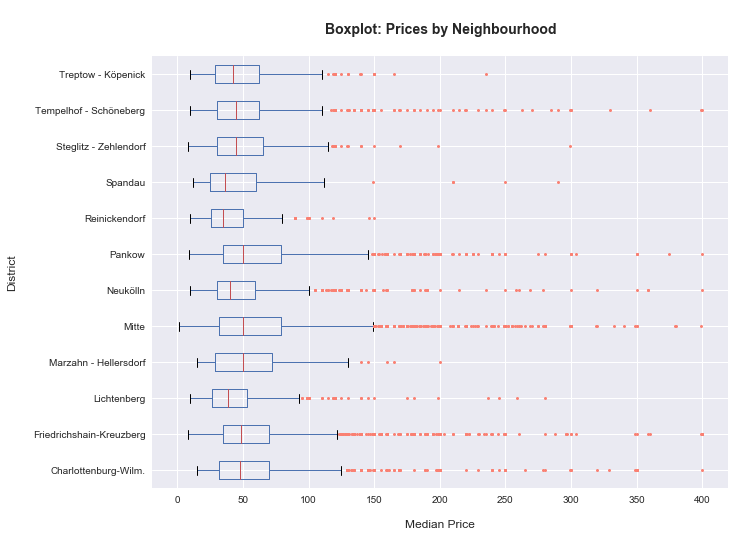

In [70]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

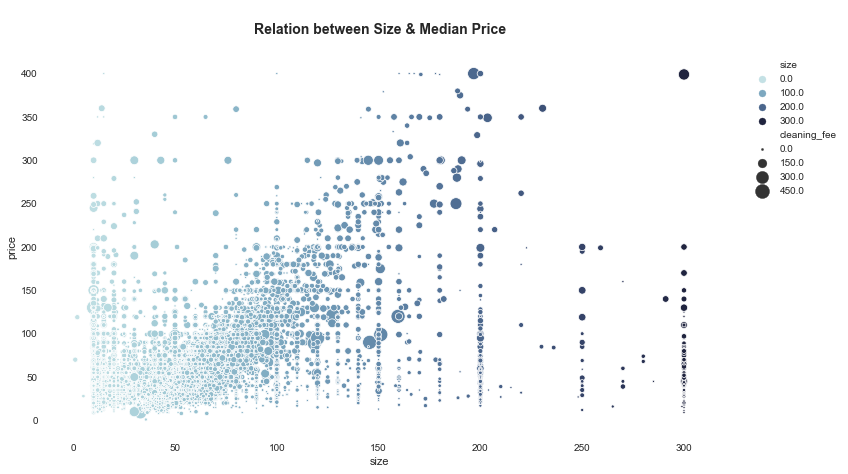

In [71]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### Modelling / Machine learning

In [72]:
df.columns

Index(['host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'bed_type', 'amenities', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'accommodates', 'bathrooms', 'bedrooms', 'price',
       'cleaning_fee', 'security_deposit', 'extra_people', 'guests_included',
       'distance', 'size', 'Wifi', 'Heating', 'Kitchen', 'Essentials',
       'Washer', 'Hair dryer', 'Laptop friendly workspace', 'Hangers', 'Iron',
       'Shampoo', 'Hot water', 'TV', 'Family/kid friendly', 'Internet',
       'Host greets you', 'Smoke detector', 'Buzzer/wireless intercom',
       'Free street parking', 'Refrigerator', 'Dishes and silverwa

In [73]:
# Drop unnecessary columns
df.drop(['latitude',
       'longitude','property_type','amenities'], axis = 1, inplace = True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17656 entries, 2015 to 29740105
Data columns (total 57 columns):
host_has_profile_pic                          17656 non-null object
host_identity_verified                        17656 non-null object
neighbourhood_group_cleansed                  17656 non-null object
room_type                                     17656 non-null object
bed_type                                      17656 non-null object
minimum_nights                                17656 non-null int64
instant_bookable                              17656 non-null object
is_business_travel_ready                      17656 non-null object
cancellation_policy                           17656 non-null object
number_of_reviews                             17656 non-null int64
review_scores_rating                          17656 non-null float64
review_scores_accuracy                        17656 non-null float64
review_scores_cleanliness                     17656 non-null float64


In [75]:
df['instant_bookable'] = df['instant_bookable'].astype('bool')
df['is_business_travel_ready'] = df['is_business_travel_ready'].astype('bool')
coltoconvert  = df.select_dtypes(include='object').columns
for i in coltoconvert:
    df[i] = df[i].astype('category')

In [76]:
numfeat = df.select_dtypes(include= ['float64', 'int64', 'bool']).copy()
catfeat = df.select_dtypes(include=['category'])
catfeat = pd.get_dummies(catfeat)
features = pd.concat([numfeat,catfeat],axis = 1)

In [80]:
features.shape

(17656, 80)

In [81]:
## Train test split
target = features[['price']]
features = features.drop(['price'], axis = 1)

In [82]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)

In [83]:
## SCALING THE DATA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test  = sc.transform(x_test)

### XGBoost regressor

In [87]:
features.isna().sum()

minimum_nights                                           0
instant_bookable                                         0
is_business_travel_ready                                 0
number_of_reviews                                        0
review_scores_rating                                     0
review_scores_accuracy                                   0
review_scores_cleanliness                                0
review_scores_checkin                                    0
review_scores_communication                              0
review_scores_location                                   0
review_scores_value                                      0
accommodates                                             0
bathrooms                                                0
bedrooms                                                 0
cleaning_fee                                             0
security_deposit                                         0
extra_people                                            

In [88]:
import xgboost

In [89]:
booster = xgboost.XGBRegressor()

Some of the important hyperparameters to tune an XGBoost are:

n_estimators  = Number of trees one wants to build.  
learning_rate  = Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.  
max_depth  = Determines how deeply each tree is allowed to grow during any boosting round.  
colsample_bytree = Percentage of features used per tree.  
gamma  = Specifies the minimum loss reduction required to make a split.  

In [90]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 200],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [3, 5, 7],
              'colsample_bytree': [0.6, 0.7],
              'gamma': [0.0, 0.1]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(x_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

[06:45:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [91]:
booster = xgboost.XGBRegressor(colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, 
                           max_depth=7, n_estimators=200, random_state=4)
booster.fit(x_train,y_train)
y_predict_test = booster.predict(x_test)

[06:45:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [84]:
from sklearn.metrics import mean_squared_error, r2_score

In [92]:
np.sqrt(mean_squared_error(y_predict_test,y_test))

22.041318223453516

### Linear Regression

In [85]:
LN = LinearRegression()
LN.fit(x_train,y_train)
y_pred = LN.predict(x_test)

In [86]:
np.sqrt(mean_squared_error(y_pred,y_test))

27.648004185121625

### Cross validation with xgboost

In [ ]:
xg_train = xgboost.DMatrix(data=x_train, label=y_train)

In [ ]:
params = {'colsample_bytree':0.7, 'gamma':0.0, 'learning_rate':0.05, 'max_depth':7}

cv_results = xgboost.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [ ]:
cv_results.tail()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
model = xgboost.XGBRegressor()
kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model, x_train, y_train, cv=kfold)

In [ ]:
results

In [ ]:
feat_importances = pd.Series(booster.feature_importances_, index=features.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

In [ ]:
data_raw.columns